# Utilizing an Exponential Function as a Intervention Function to Model a Time Series: Beginning of the Pandemic (Gradual Decrease)

In this analysis, we will focus on the application of a statistical time series model to forecast passenger mobility and vehicle dispatch data. The data covers the period from July 2019 to August 2023, with a daily frequency, and is provided by the Ministry of Transportation of Colombia through its logistics portal.

The main objective of this study is to develop a model that allows for accurate forecasts of future mobility based on historical patterns and observed trends in the data. To achieve this, we will employ time series and statistical modeling techniques.

This modeling approach will provide a valuable tool for decision-making related to transportation planning and management in Colombia. Throughout this analysis, we will present the selected statistical model and discuss the forecast results derived from it.

Data source: https://www.datos.gov.co/Transporte/Operaci-n-de-pasajeros-y-despacho-de-veh-culos-en-/eh75-8ah6.  
Author: Miguel Pardo  
e-mail: mpstatistical@gmail.com

In [40]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
from statsmodels.tsa.stattools import adfuller
import pmdarima as pm
import statsmodels.api as sm
import seaborn as sns
# Set Seaborn style
sns.set(style="whitegrid")  # You can choose the style you prefer

# Set the font for all text in the plots
sns.set(font_scale=1.2)  # Adjust font size according to your preference
plt.rc('font', family='serif', serif='Times New Roman')

In [41]:
serie_mensual = pd.read_csv("serie_mensual.csv")
serie_mensual_pandemia = pd.read_csv("serie_mensual_pandemia.csv")
# Assuming that 'FECHA' is the column containing dates in both DataFrames
serie_mensual['FECHA'] = pd.to_datetime(serie_mensual['FECHA'])
serie_mensual_pandemia['FECHA'] = pd.to_datetime(serie_mensual_pandemia['FECHA'])

# Concatenate the DataFrames
serie_combinada = pd.concat([serie_mensual, serie_mensual_pandemia])

# Sort the resulting DataFrame by the 'FECHA' column
serie_combinada.sort_values(by='FECHA', inplace=True)

# Reset the index
serie_combinada.reset_index(drop=True, inplace=True)

# Display the combined DataFrame
time_series = serie_combinada

In [42]:
# Create a filter to select dates prior to or equal to August 31, 2023
date_filter = time_series['FECHA'] <= '2023-08-31'

# Apply the filter to the DataFrame to remove rows with dates after the specified date
time_series = time_series[date_filter]

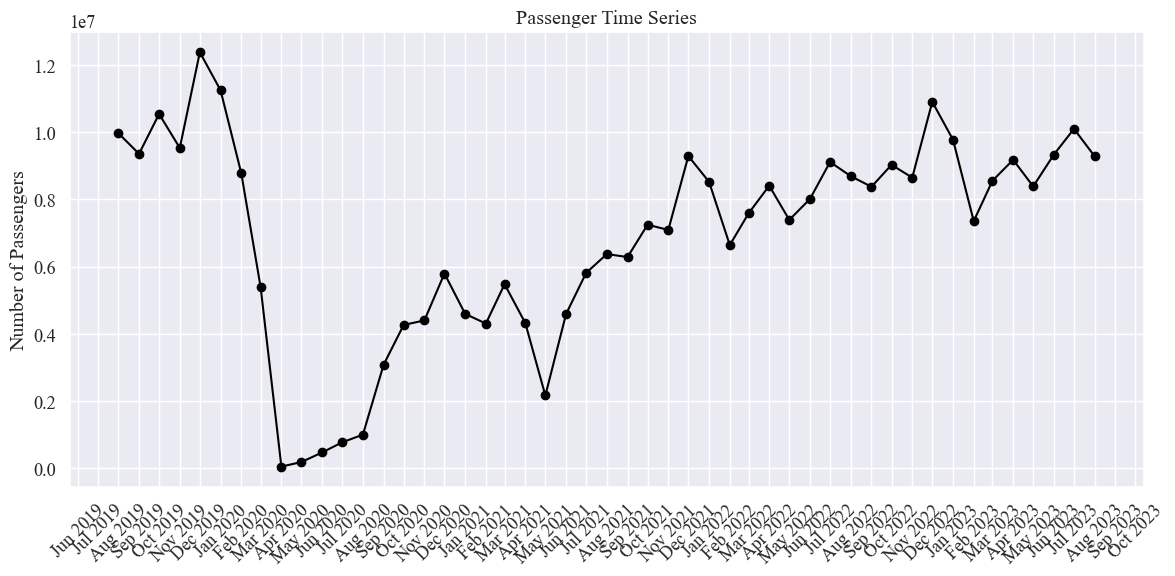

In [43]:
import matplotlib.dates as mdates

# Create the figure and the plot
plt.figure(figsize=(12, 6))
plt.plot(time_series['FECHA'], time_series['PASAJEROS'], marker='o', linestyle='-', color='black')
plt.title('Passenger Time Series')
plt.ylabel('Number of Passengers')
plt.grid(True)

# Format the x-axis labels
ax = plt.gca()
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))  # Format: Month and Year
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))  # Interval of 1 month

# Rotate labels for better visibility
plt.xticks(rotation=45)

# Show the plot
plt.tight_layout()
plt.show()



In [44]:
def test_stationarity(time_series, num_diff=0, return_series=False):
    """
    Perform the ADF test to determine the stationarity of a time series.

    Args:
        time_series (pd.Series): The time series to analyze.
        num_diff (int): Number of differencings to apply before the test (default: 0).
        return_series (bool): Whether to return the differenced time series (default: False).

    Returns:
        p_value (float): The p-value obtained from the ADF test.
    """
    # Apply differencing if necessary
    if num_diff > 0:
        time_series = time_series.diff(periods=num_diff).dropna()

    # Perform the ADF test
    result = adfuller(time_series)  # We do not handle missing values here

    # Print result details
    print("ADF Test Result:")
    print(f"P-Value: {result[1]}")
    print("Test Statistics:")
    print(f"ADF Statistic: {result[0]}")
    print("Critical Values:")
    for key, value in result[4].items():
        print(f"   {key}: {value}")

    # Interpret the result
    if result[1] <= 0.05:
        print("The time series is stationary (reject the null hypothesis).")
    else:
        print("The time series is not stationary (null hypothesis is not rejected).")

    if return_series:
        return time_series

    # Plot the time series
    plt.figure(figsize=(10, 6))
    plt.plot(time_series, marker='o', linestyle='-', color='black')
    plt.title("Time Series")
    plt.grid(True)
    plt.xlabel("Time")
    plt.ylabel("Value")



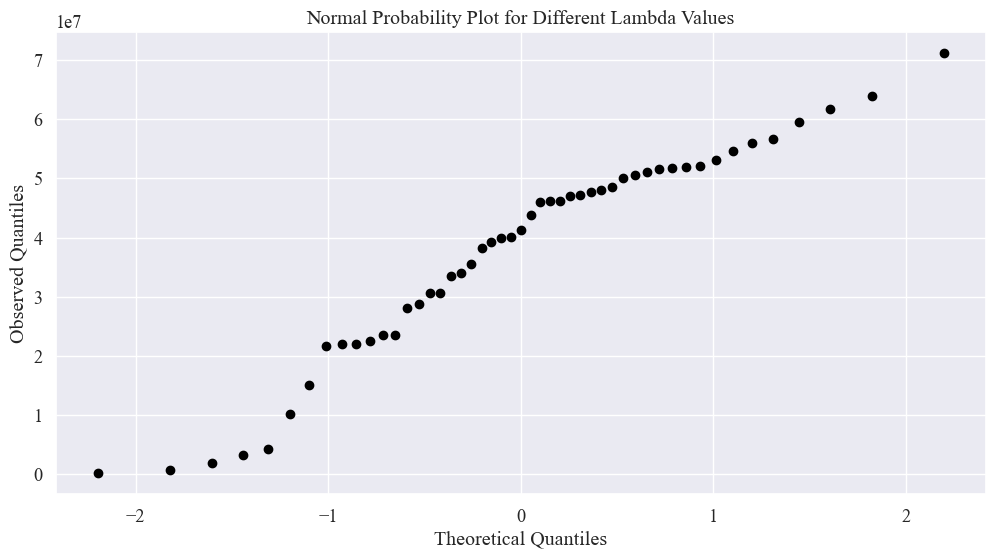

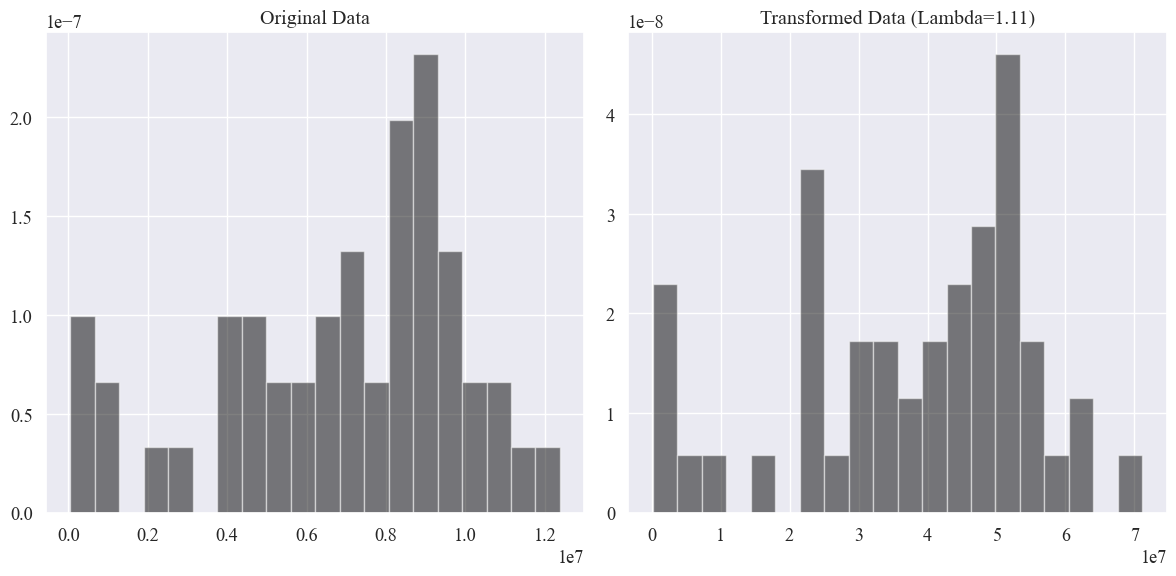

Best found lambda: 1.11


In [45]:
# Extract the data series
data = time_series['PASAJEROS']

# Generate a normal probability plot for different lambda values
_, fitted_lambda = stats.boxcox(data)
probplot, _ = stats.probplot(stats.boxcox(data, lmbda=fitted_lambda), plot=None)

# Find the best lambda value
best_lambda = fitted_lambda

# Plot the normal probability plot
plt.figure(figsize=(12, 6))
plt.scatter(probplot[0], probplot[1], marker='o', color='black')
plt.title('Normal Probability Plot for Different Lambda Values')
plt.xlabel('Theoretical Quantiles')
plt.ylabel('Observed Quantiles')

# Apply the Box-Cox transformation with the best lambda
transformed_data = stats.boxcox(data, lmbda=best_lambda)

# Plot the original and transformed data
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.hist(data, bins=20, density=True, color='black', alpha=0.5)
plt.title('Original Data')

plt.subplot(1, 2, 2)
plt.hist(transformed_data, bins=20, density=True, color='black', alpha=0.5)
plt.title(f'Transformed Data (Lambda={best_lambda:.2f})')

plt.tight_layout()
plt.show()

print(f"Best found lambda: {best_lambda:.2f}")

#time_series['PASAJEROS'] = transformed_data.astype(float)
#time_series['PASAJEROS'] = np.log(time_series['PASAJEROS'])

No Box-Cox transformation is required.

## Stationarity verification.

ADF Test Result:
P-Value: 0.9205176059293425
Test Statistics:
ADF Statistic: -0.3342091724378825
Critical Values:
   1%: -3.6055648906249997
   5%: -2.937069375
   10%: -2.606985625
The time series is not stationary (null hypothesis is not rejected).


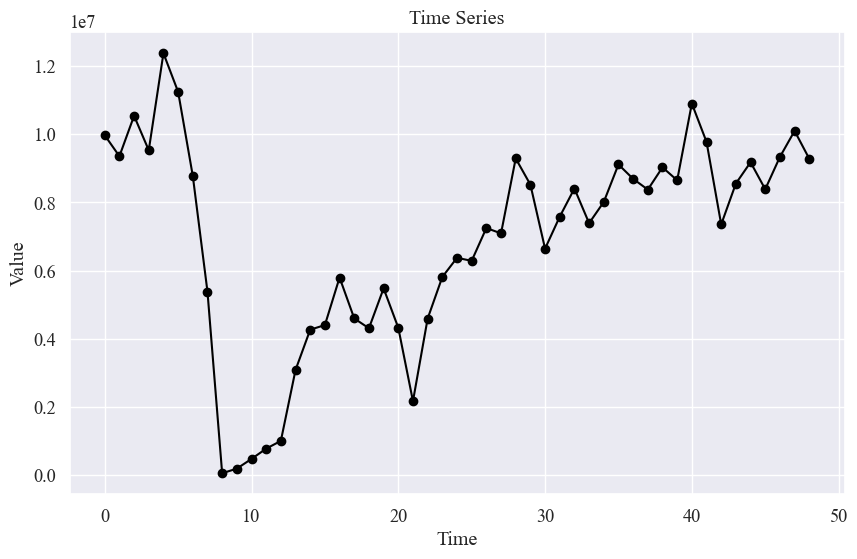

In [46]:
test_stationarity(time_series['PASAJEROS'], num_diff = 0)

ADF Test Result:
P-Value: 4.46368952857354e-08
Test Statistics:
ADF Statistic: -6.250609921982598
Critical Values:
   1%: -3.6055648906249997
   5%: -2.937069375
   10%: -2.606985625
The time series is stationary (reject the null hypothesis).


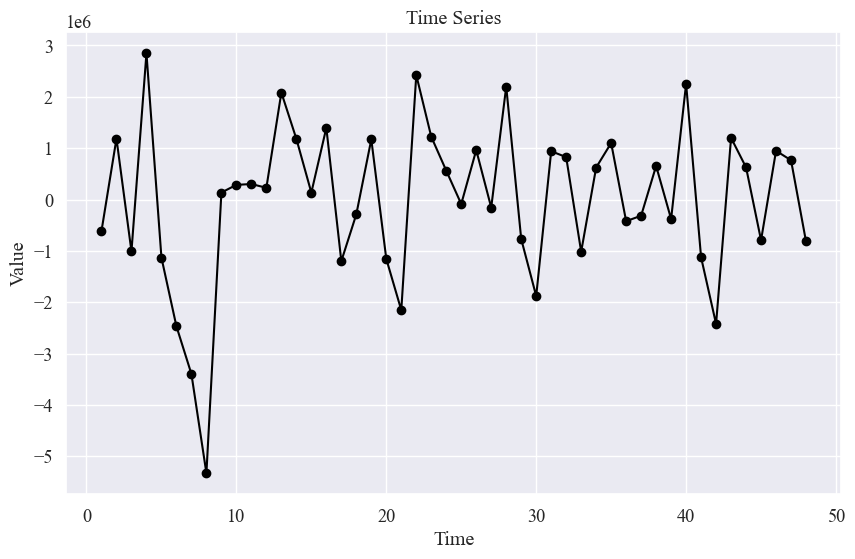

In [47]:
test_stationarity(time_series['PASAJEROS'], num_diff = 1)

## Model


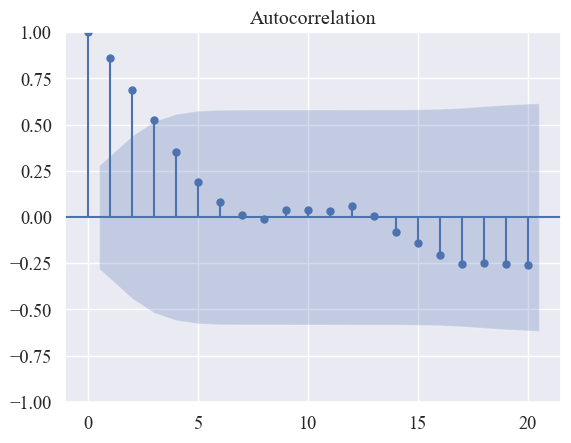

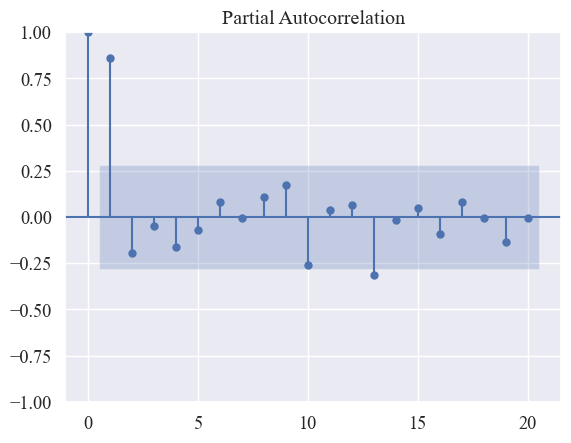

In [48]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(time_series['PASAJEROS'], lags=20)
plot_pacf(time_series['PASAJEROS'], lags=20, method='ywm')
plt.show()

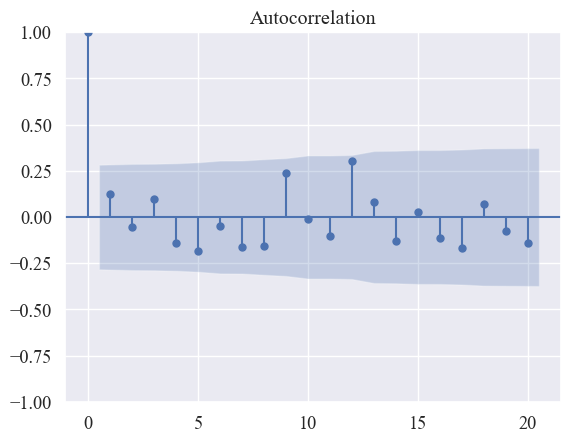

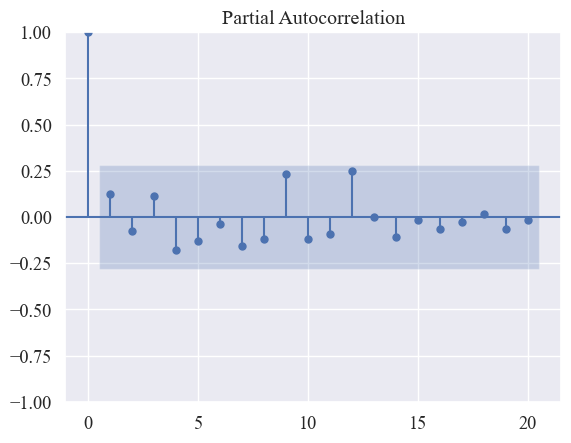

In [49]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(time_series['PASAJEROS'].diff(periods = 1).dropna(), lags=20)
plot_pacf(time_series['PASAJEROS'].diff(periods = 1).dropna(), lags=20, method='ywm')
plt.show()

### Seasonality.

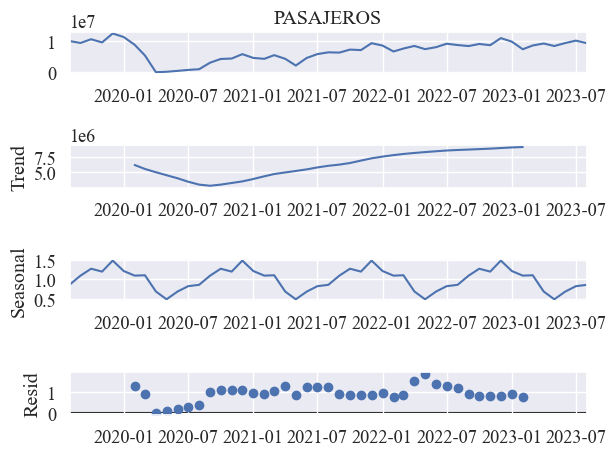

In [50]:
from statsmodels.tsa.seasonal import seasonal_decompose
time_series.set_index('FECHA', inplace=True)

# Suponiendo que 'FECHA' es la columna que contiene las fechas y 'PASAJEROS' es la serie de tiempo
result = seasonal_decompose(time_series['PASAJEROS'], model='multiplicative')
result.plot()
plt.show()


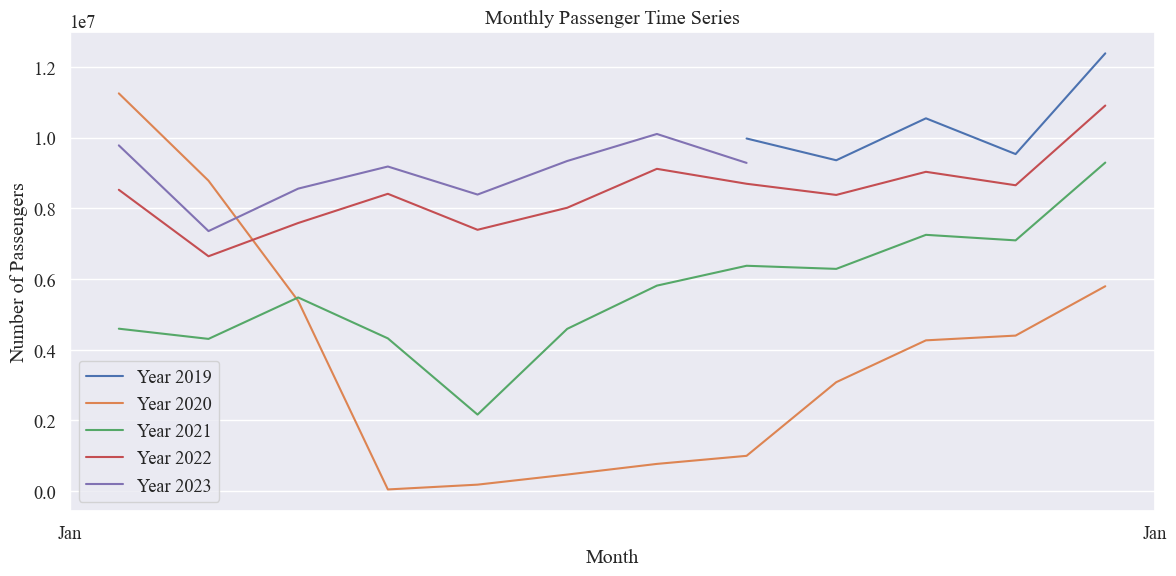

In [52]:
# Create the figure and the plot
plt.figure(figsize=(12, 6))

# Get unique years in the data
unique_years = time_series.index.year.unique()

# Iterate over the years and plot the time series
for year in unique_years:
    year_data = time_series[time_series.index.year == year]
    plt.plot(year_data.index.month, year_data['PASAJEROS'], label=f'Year {year}')

# Configure x-axis labels to display only months
ax = plt.gca()
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b'))  # '%b' shows only the month's name
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))  # Interval of 1 month

# Configure labels and title
plt.xlabel('Month')
plt.ylabel('Number of Passengers')
plt.title('Monthly Passenger Time Series')

# Show a legend
plt.legend()

# Show the plot
plt.grid(True)
plt.tight_layout()
plt.show()



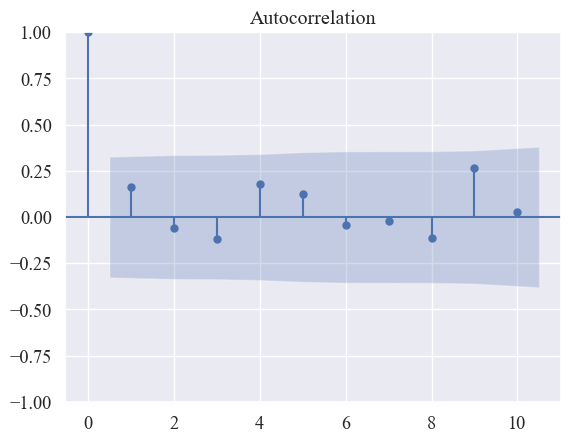

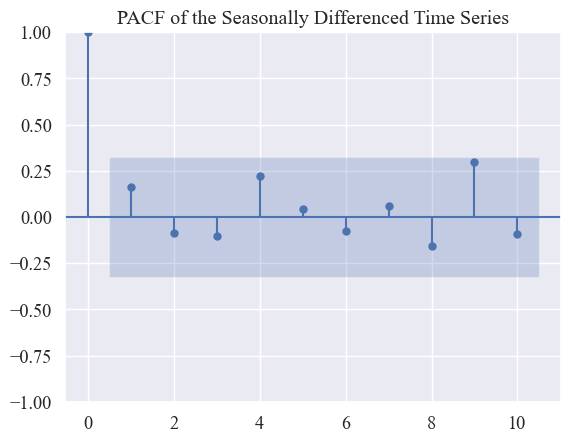

In [53]:
time_series_diff = time_series['PASAJEROS'].diff(periods=1).dropna()

# Seasonal differencing to remove seasonality (e.g., monthly seasonality)
time_series_seasonal_diff = time_series_diff.diff(periods=12).dropna()

# Plot the PACF of the seasonally differenced time series
plot_acf(time_series_seasonal_diff, lags=10)
plot_pacf(time_series_seasonal_diff, lags=10, method='ywm')
plt.title('PACF of the Seasonally Differenced Time Series')

plt.show()



In [54]:
time_series.index = pd.to_datetime(time_series.index)
time_series = time_series.asfreq('MS')

## Parameters estimation

                                     SARIMAX Results                                      
Dep. Variable:                          PASAJEROS   No. Observations:                   49
Model:             SARIMAX(0, 1, 0)x(2, 1, 0, 12)   Log Likelihood                -753.096
Date:                            Sat, 21 Oct 2023   AIC                           1514.191
Time:                                    21:13:53   BIC                           1520.525
Sample:                                08-01-2019   HQIC                          1516.402
                                     - 08-01-2023                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Impulse    -9.023e+06   3.14e-11  -2.87e+17      0.000   -9.02e+06   -9.02e+06
ar.S.L12      -0.5013      0.008   

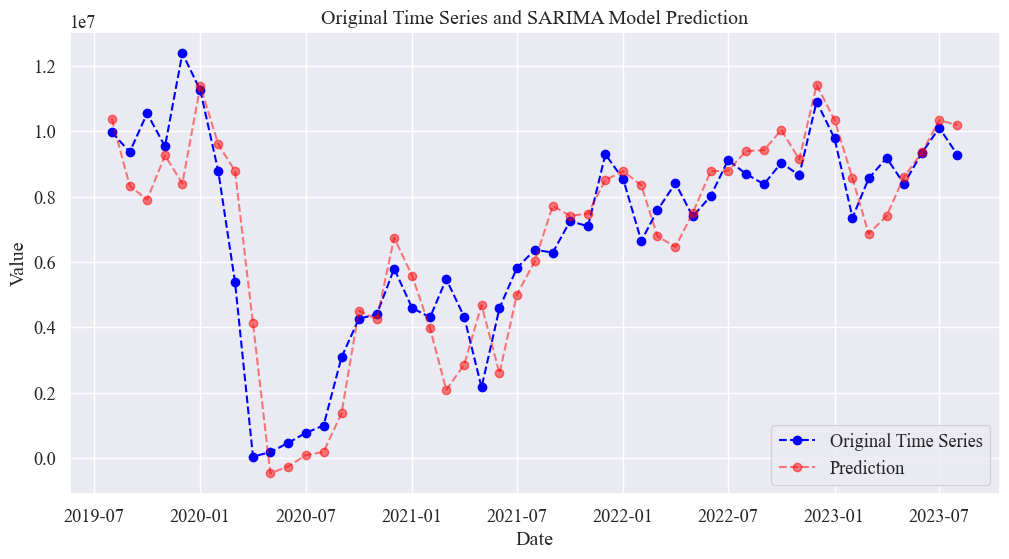

In [102]:
start_pandemic = pd.to_datetime('2020-04-01')
end_pandemic = pd.to_datetime('2020-11-01')

# Calculate the impulse value using a custom impulse equation (monthly)
def intervention_function(date):
    t = (date - start_pandemic).days // 30  # Months since the start of the pandemic
    
    # Custom monthly impulse equation
    decay = np.exp(-0.05 * t)  # Decaying exponential function
    growth = 1 - np.exp(-0.05 * (t - 2))  # Growing exponential function
    
    # Combine the two functions to get the complete impulse
    impulse = decay * growth
    
    return impulse

impulse = pd.DataFrame()
impulse['Impulse'] = time_series.index.map(intervention_function)
impulse.set_index(time_series.index, inplace=True)

model = sm.tsa.SARIMAX(time_series['PASAJEROS'],
                        exog=impulse['Impulse'],
                        order=(0, 1, 0),
                        seasonal_order=(2, 1, 0, 12))

results = model.fit()

# Print the model summary (optional)
print(results.summary())

# Plot the original time series and the prediction
plt.figure(1, figsize=(12, 6))
plt.plot(time_series.index, time_series['PASAJEROS'], marker='o', linestyle='--', label='Original Time Series', color='blue')
plt.plot(results.predict(start=0, end=len(time_series) - 1), marker='o', linestyle='--', label='Prediction', color='red', alpha=0.5)
plt.legend()
plt.xlabel('Date')
plt.grid(True)
plt.ylabel('Value')
plt.title('Original Time Series and SARIMA Model Prediction')
plt.show()

# Calculate the Shapiro-Wilk test for residuals


### Normality

Shapiro-Wilk Test Statistic: 0.9628638029098511
Shapiro-Wilk Test p-Value: 0.1570042371749878


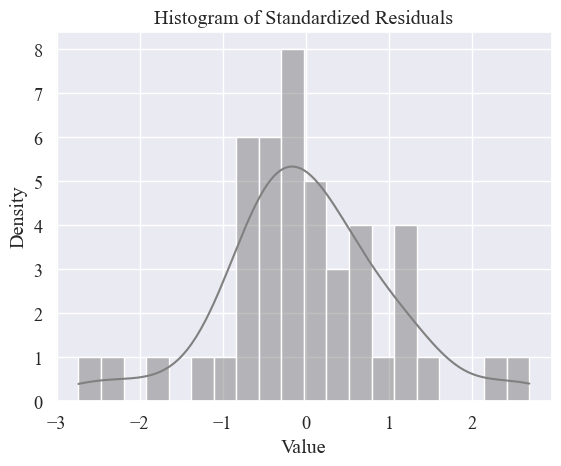

In [104]:
res = results.resid.values

# Take the data from the fifth element (index 4)
res = res[4:]

# Calculate the mean and standard deviation of the residuals
mean_residuals = np.mean(res)
standard_deviation_residuals = np.std(res)

# Standardize the residuals
standardized_residuals = (res - mean_residuals) / standard_deviation_residuals

# Perform the Shapiro-Wilk test
shapiro_test_statistic, shapiro_p_value = stats.shapiro(standardized_residuals)
print(f'Shapiro-Wilk Test Statistic: {shapiro_test_statistic}')
print(f'Shapiro-Wilk Test p-Value: {shapiro_p_value}')

# Create a histogram of the standardized residuals with KDE
sns.histplot(standardized_residuals, kde=True, bins=20, color='grey', label='Standardized Residuals')
plt.xlabel('Value')
plt.ylabel('Density')
plt.title('Histogram of Standardized Residuals')
plt.show()


## No correlation in the errors

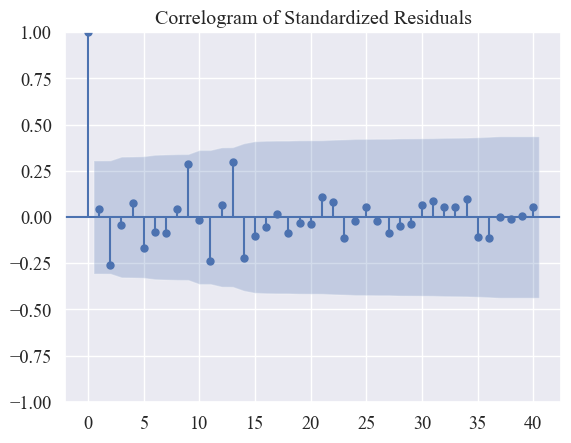

In [117]:
# Change the color of the vertical lines
sm.graphics.tsa.plot_acf(standardized_residuals[4:], lags=40, title='Correlogram of Standardized Residuals')
plt.show()


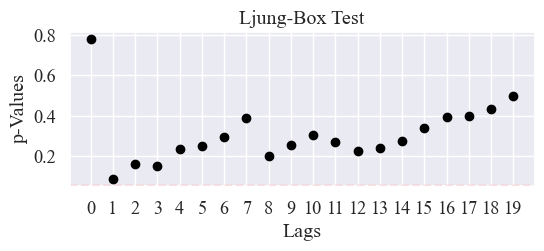

In [118]:
plt.figure(figsize=(6, 2))

# Draw the plot of the values
plt.scatter(range(len(resultados.test_serial_correlation(method='ljungbox', lags=20)[0][1])),
         resultados.test_serial_correlation(method='ljungbox', lags=20)[0][1],
         marker='o', color='black')

# Add a dashed red line at the point 0.05
plt.axhline(y=0.05, color='red', linestyle='--')

# Label the axes and add a title
plt.xlabel('Lags')
plt.ylabel('p-Values')
plt.title('Ljung-Box Test')
integer_x_values = list(range(len(resultados.test_serial_correlation(method=None, lags=20)[0][1])))
plt.xticks(integer_x_values)

# Show the plot
plt.show()


## Homoscedasticity

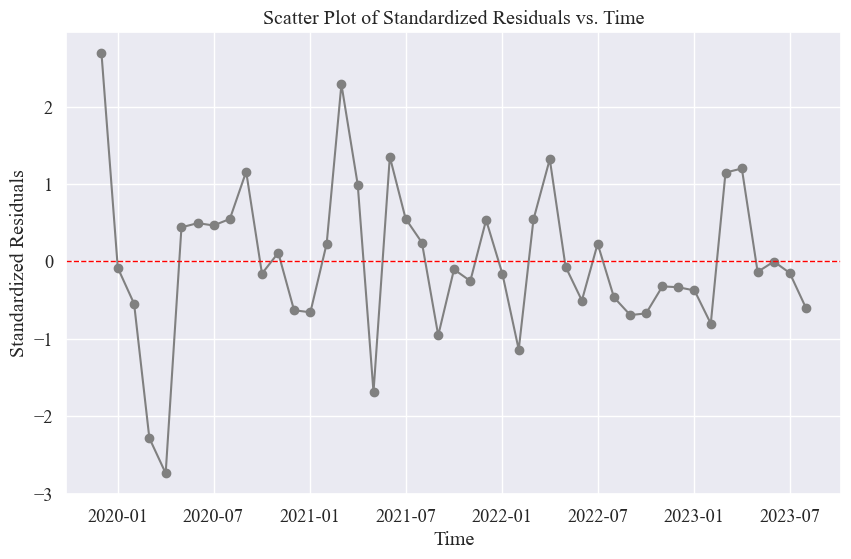

In [119]:
# Standardize the residuals and assign them to the 'res' variable
res_standardized = (results.resid[4:] - np.mean(results.resid[4:])) / np.std(results.resid[4:])

# Scatter plot of standardized residuals vs. time
plt.figure(figsize=(10, 6))
plt.plot(results.resid.index[4:], res_standardized, color='grey', marker='o')
plt.axhline(y=0, color='red', linestyle='--', linewidth=1)
plt.xlabel('Time')
plt.ylabel('Standardized Residuals')
plt.title('Scatter Plot of Standardized Residuals vs. Time')
plt.grid(True)
plt.show()




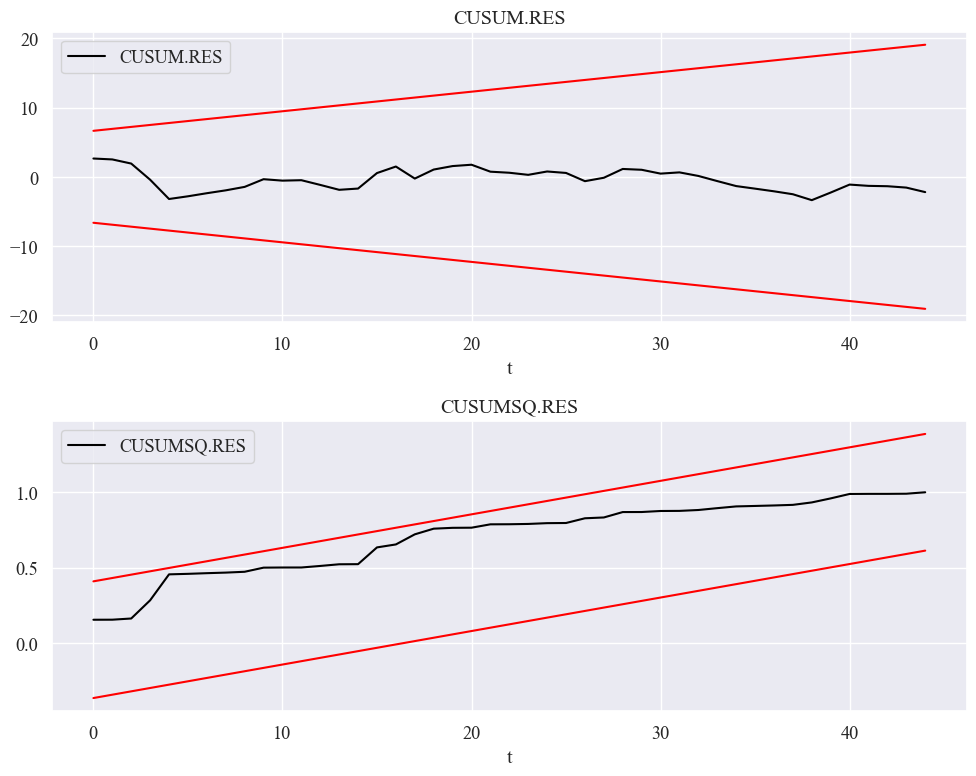

In [120]:
residuals = results.resid.values

# Calculate the mean and standard deviation of the residuals
mean_residuals = np.mean(residuals)
std_dev_residuals = np.std(residuals)

# Standardize the residuals and assign them to the 'res' variable
res = (residuals - mean_residuals) / std_dev_residuals
res = res[4:]
# Now, 'res' contains the standardized residuals

# Calculation of CUSUM
cusum = np.cumsum(res) / np.std(res)
N = len(res)

# Calculation of CUSUMSQ
cusumsq = np.cumsum(res**2) / np.sum(res**2)

# Quantiles for CUSUM and CUSUMSQ
Af = 0.948  # 95% quantile for CUSUM statistic
co = 0.1548 * 2.5  # Approximate quantile value for CUSUMSQ for n/2

# Limits for CUSUM.RES
LS = Af * np.sqrt(N) + 2 * Af * np.arange(1, N+1) / np.sqrt(N)
LI = -LS

# Limits for CUSUMSQ.RES
LQS = co + np.arange(1, N+1) / N
LQI = -co + np.arange(1, N+1) / N

# Plots
plt.figure(figsize=(10, 8))
plt.subplot(2, 1, 1)
plt.plot(cusum, color="black", label="CUSUM.RES")
plt.plot(LS, color="red", linestyle="-")
plt.plot(LI, color="red", linestyle="-")
plt.xlabel("t")
plt.ylabel("")
plt.title("CUSUM.RES")
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(cusumsq, color="black", label="CUSUMSQ.RES")
plt.plot(LQS, color="red", linestyle="-")
plt.plot(LQI, color="red", linestyle="-")
# plt.ylim(-10, 1.5)
plt.xlabel("t")
plt.ylabel("")
plt.title("CUSUMSQ.RES")
plt.legend()

plt.tight_layout()
plt.show()


#### F-test (one tail)

In [121]:
from statsmodels.stats.diagnostic import het_breuschpagan

# Get the residuals from the ARIMA model
residuals = res

# Create a linear regression with lags of the residuals
lags = 10  # You can adjust the number of lags to consider

# Add lags manually
X = np.column_stack((np.ones_like(residuals[lags:]), residuals[:-lags]))
y = residuals[lags:]

# Fit the linear regression
linear_model = sm.OLS(y, X)
linear_results = linear_model.fit()

# Perform the Breusch-Pagan test on the linear regression
breusch_pagan_test = het_breuschpagan(linear_results.resid, X)
print("Breusch-Pagan Test Statistic:", breusch_pagan_test[0])
print("p-Value:", breusch_pagan_test[1])



Breusch-Pagan Test Statistic: 1.20912706520652
p-Value: 0.27150507332379054


## Forecast

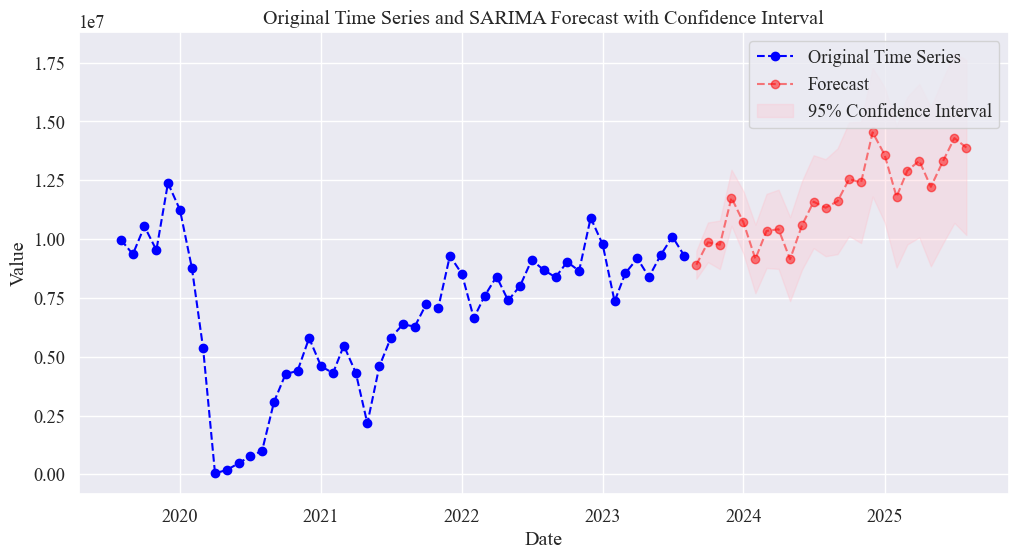

In [122]:
# Forecast for an additional year (12 months)
forecast_steps = 24
forecast = results.get_forecast(steps=forecast_steps, exog=impulse['Impulse'][-forecast_steps:])

# Get the forecasted values and confidence intervals
forecast_mean = forecast.predicted_mean
forecast_conf_int = forecast.conf_int()

# Plot the original time series and the forecast
plt.figure(figsize=(12, 6))
plt.plot(time_series.index, time_series['PASAJEROS'], marker='o', linestyle='--', label='Original Time Series', color='blue')
plt.plot(forecast_mean.index, forecast_mean.values, marker='o', linestyle='--', label='Forecast', color='red', alpha=0.5)
plt.fill_between(forecast_conf_int.index, forecast_conf_int.iloc[:, 0], forecast_conf_int.iloc[:, 1], color='pink', alpha=0.3, label='95% Confidence Interval')
plt.legend()
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Original Time Series and SARIMA Forecast with Confidence Interval')
plt.show()

In [123]:
# Forecast for an additional year (12 months)
forecast_steps = 24
forecast = results.get_forecast(steps=forecast_steps, exog=impulse['Impulse'][-forecast_steps:])

# Get the forecasted values and confidence intervals
forecast_mean = forecast.predicted_mean
forecast_conf_int = forecast.conf_int()

# Calculate the Mean Squared Error (MSE)
actual_values = time_series['PASAJEROS'][-forecast_steps:]

# Create a DataFrame with forecasted values and confidence intervals
forecast_df = pd.DataFrame({
    'Forecast': forecast_mean,
    'Lower Confidence Interval': forecast_conf_int.iloc[:, 0],
    'Upper Confidence Interval': forecast_conf_int.iloc[:, 1]
})

# Display the forecast DataFrame
forecast_df



,Forecast,Lower Confidence Interval,Upper Confidence Interval
2023-09-01,8.911190e+06,8.316110e+06,9.506270e+06
2023-10-01,9.864483e+06,9.022912e+06,1.070605e+07
2023-11-01,9.758781e+06,8.728072e+06,1.078949e+07
2023-12-01,1.176070e+07,1.057054e+07,1.295086e+07
2024-01-01,1.071216e+07,9.381520e+06,1.204280e+07
2024-02-01,9.158782e+06,7.701139e+06,1.061642e+07
2024-03-01,1.034883e+07,8.774392e+06,1.192326e+07
2024-04-01,1.041975e+07,8.736608e+06,1.210289e+07
2024-05-01,9.149644e+06,7.364404e+06,1.093488e+07
2024-06-01,1.059032e+07,8.708511e+06,1.247213e+07


Beginning of the Pandemic (Gradual Decrease): When the pandemic begins, its impact on the time series is neither immediate nor sudden. It has a gradual effect on reducing the number of passengers. Therefore, the impulse function starts at zero before the onset of the pandemic and gradually begins to increase.

Exponential Decreasing Function (Decrease): The first part of the impulse function, decrease = np.exp(-0.05 * t), represents the gradual decrease in the impact of the pandemic. An exponential decreasing function is used to model this decrease. As time passes from the start of the pandemic, this function decreases, indicating that the effect of the pandemic diminishes over time.

Exponential Growth Function (Increase Before the End of the Pandemic): The second part of the impulse function, growth = 1 - np.exp(-0.05 * (t - 2)), represents the gradual increase in the months leading up to the end of the pandemic. An exponential growth function is used to model this increase. This reflects that the effect of the pandemic may intensify before the situation begins to improve.

Combining the Functions: The two functions, decrease and growth, are combined multiplicatively to obtain the complete impulse. This allows the impulse function to behave realistically throughout the pandemic period, with a gradual increase, a peak, and then a gradual decrease.

The forecast equation would be:

$
\hat{Y}_{t+h} = -6.409 \times 10^6 \times fun_intervention{t+h} - 0.4862 \times \phi_{t+h-12} - 0.3532 \times \phi_{t+h-24}
$

Where:

- $\hat{Y}_{t+h}$ is the forecasted value at time \(t+h\).

- $fun_intervention{t+h}$ represents the impulse series created by the `fun_intervention(fecha)` function used as an exogenous variable in the model.
- $\phi_{t+h-12}$ and \(\phi_{t+h-24}\) are the autoregressive values with a seasonal lag of 12 and 24 months, respectively.

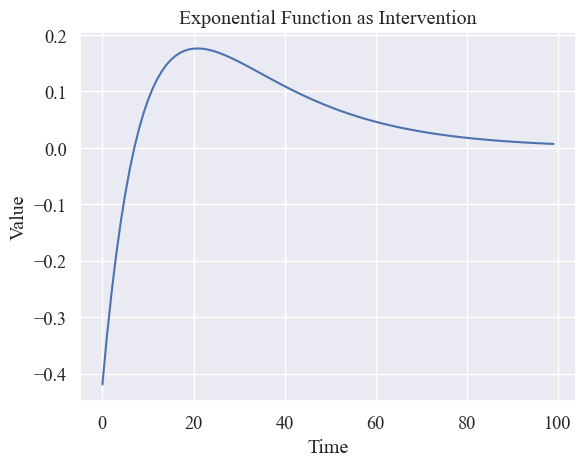

In [124]:
import numpy as np
import matplotlib.pyplot as plt

A = np.array([1 - np.exp(-0.05 * (t - 7)) for t in range(0, 100)]) * np.array([np.exp(-0.05 * t) for t in range(0, 100)])

# Create the plot with the specified title
plt.plot([i for i in range(0, 100)], A)
plt.title('Exponential Function as Intervention')
plt.xlabel('Time')
plt.ylabel('Value')
plt.show()
